In [1]:
from sobol import sobolIndices, inputParam
import numpy as np

from scipy.stats import uniform, norm

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Parallel floris example

## Starting cluster

In [3]:
import ipyparallel as ipp

def show_clusters():
    clusters = ipp.ClusterManager().load_clusters() 
    print("{:15} {:^10} {}".format("cluster_id", "state", "cluster_file")) 
    for c in clusters:
        cd = clusters[c].to_dict()
        cluster_id = cd['cluster']['cluster_id']
        controller_state = cd['controller']['state']['state']
        cluster_file = getattr(clusters[c], '_trait_values')['cluster_file']
        print("{:15} {:^10} {}".format(cluster_id, controller_state, cluster_file))

# cluster = ipp.Cluster(n=4, engines='mpi')
# await cluster.start_cluster() 

# show_clusters()

In [42]:
from ipyparallel import Client, error
rc = Client(profile="mpi")

In [43]:
%px foo = 5

print(rc[:]['foo'])
rc[:]['bar'] = lambda : 2 * foo
rc[:].apply_sync(parallel.Reference('bar'))

CompositeError: one or more exceptions raised in: _pull
[0:apply]NameError: name 'foo' is not defined
[1:apply]NameError: name 'foo' is not defined
[2:apply]NameError: name 'foo' is not defined
[3:apply]NameError: name 'foo' is not defined

In [ ]:
%px print("hello, world!")

In [ ]:
view = rc[:]

view.activate() # enable magics

In [11]:
view.run('psum.py')

<AsyncResult(execute): pending>

In [22]:
view.scatter('a', np.arange(32,dtype='float'))

<AsyncResult(scatter): pending>

In [23]:
view['a']

[array([0., 1.]),
 array([2., 3.]),
 array([4., 5.]),
 array([6., 7.]),
 array([8., 9.]),
 array([10., 11.]),
 array([12., 13.]),
 array([14., 15.]),
 array([16., 17.]),
 array([18., 19.]),
 array([20., 21.]),
 array([22., 23.]),
 array([24., 25.]),
 array([26., 27.]),
 array([28., 29.]),
 array([30., 31.])]

In [25]:
%%px
totalsum = psum(a)

<AsyncResult(%px): pending>

TypeError: names must be strs, not array(496.)

In [29]:
from mpi4py import MPI
import numpy as np

def psum(a):
    locsum = np.sum(a)
    rcvBuf = np.array(0.0, 'd')
    MPI.COMM_WORLD.Allreduce([locsum, MPI.DOUBLE],
        [rcvBuf, MPI.DOUBLE],
        op=MPI.SUM)
    return rcvBuf

In [16]:
from floris.tools import FlorisInterface
import yaml
import pandas as pd

In [45]:
param_names = ['wd', 'ws', 'ti', 'n_turb', 'n_comb']

df = pd.read_csv('/nobackup1/kklemmer/VW1_data/NREL_VW1_140m_2017.csv', header=2)

ti = np.divide(np.sqrt(2*np.array(df['turbulent kinetic energy at 140m (m2/s2)'])),
               np.array(df['wind speed at 140m (m/s)']))

df_dict = {'wd' : np.array(df['wind direction at 140m (deg)']), 
           'ws' : np.array(df['wind speed at 140m (m/s)']),
           'ti' : ti}

wd_ws_ti_df = pd.DataFrame(data=df_dict)

# ti_df = wd_ws_ti_df.copy()
# ti_df['wd'] = 270
# ti_df['ws'] = 10

ka_prior = uniform(loc=0, scale=0.38)
kb_prior = uniform(loc=0, scale=0.004)
n_prior = uniform(loc=1, scale=1)

input_params = {'wd_ws_ti' : inputParam(wd_ws_ti_df, group=True),
                'n_turb' : inputParam(n_prior),
                'n_comb' : inputParam(n_prior)}

indices = sobolIndices(model=floris_model_func_parallel, params=input_params, model_params = param_names, N=100)

100


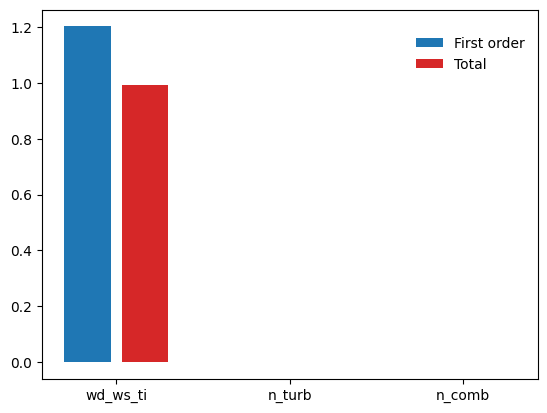

In [31]:
fig, ax = plt.subplots()

i = 0
for _,param in indices.params.items():
    if i==0:
        ax.bar(i, param.s1, color='tab:blue', label='First order')
        ax.bar(i+1, param.sT, color='tab:red', label = 'Total')
    else:
        ax.bar(i, param.s1, color='tab:blue')
        ax.bar(i+1, param.sT, color='tab:red')
    i+=3
    
xlabels = input_params.keys()

xticks = [1/2 + j*3 for j in range(len(xlabels))]

ax.set_xticks(xticks)

ax.set_xticklabels(xlabels)
    
fig.legend(frameon=False, bbox_to_anchor=(0.9,0.85))

In [17]:
# functions for combining floris and sobol

def make_model_params_dict(matrix, param_names):
    model_params = {}
    
    for i in range(len(param_names)):
        model_params[param_names[i]] = matrix[:,i]
        
    return model_params

def update_fi_params(fd, model_params, row):
    for key in model_params:
        # check for input wind condition parameters
        if key == 'wd':
            fd['flow_field']['wind_directions'] = [model_params['wd'][row]]
        elif key == 'ws':
            fd['flow_field']['wind_speeds'] = [model_params['ws'][row]]
        elif key == 'ti':
            fd['flow_field']['turbulence_intensity'] = model_params['ti'][row]

        # check for wake model form parameters
        elif key == 'n_turb':
            fd['wake']['wake_turbulence_parameters']['crespo_hernandez']['n'] = model_params['n_turb'][row]
        elif key == 'n_comb':
            fd['wake']['wake_combination_parameters']['sosfs']['n'] = model_params['n_comb'][row]
        # check for wake model parameters
        # for now use predefined parameters so the searching isn't an issue
        elif key == 'ka':
            fd['wake']['wake_velocity_parameters']['gauss']['ka'] = model_params['ka'][row]
        elif key == 'kb':
            fd['wake']['wake_velocity_parameters']['gauss']['kb'] = model_params['kb'][row]
        else: 
            print("Key {} not found. Available parameters to change are wd, ws, ti, ka, and kb.".format(key))
            
    # create new floris interface with updated parameters
    fi = FlorisInterface(fd)
    
    return fi
        
def farm_power_calc(fi):

    # Calculate FLORIS for the WD,WS,TI combination                                                                                                                               
    fi.calculate_wake()

    # Calculate farm power                                                                                                                                                        
    # Sort out NaN and negative turbine power values                                                                                                                              
    turbine_power = fi.get_turbine_powers()
    turbine_power[turbine_power<0] = 0
    turbine_power = np.nan_to_num(turbine_power)

    # Return the farm power from the above calculation in W                                                                                                                       
    farm_power = np.sum(turbine_power)

    return farm_power

def floris_model_func(input_params_matrix, param_names):
    # Function that is given as an input to the sobolIndices class
    # Needs to take a matrix of input parameter samples and output farm power
    # param_names is also given to parse the names of the parameters

    fi = FlorisInterface('/home/kklemmer/floris/examples/inputs/gch.yaml')
    
        ### Define farm orientation ###                                                                                                                                               
    df_tl = pd.read_csv('/home/kklemmer/floris/examples/inputs/VW1_turbine_locations_byD.csv', header=None)

    # turbine hub height (IEA Wind 15MW)                                                                                                                                           
    H = 140
    # rotor diameter (IEA Wind 15-MW)                                                                                                                                              
    D = 150

    # x coordinates                                                                                                                                                               
    x_coords = np.array(df_tl[0])
    layout_x = D*x_coords
    #y coordinates                                                                                                                                                                
    y_coords = np.array(df_tl[1])
    layout_y = D*y_coords

    # Reinitialize with layout from previous relevant kernel                                                                                                                      
    fi.reinitialize(layout_x=layout_x, layout_y=layout_y)
    
    with open('/home/kklemmer/floris/examples/inputs/gch.yaml', 'r') as stream:
        fd=yaml.safe_load(stream)
            
            
    fd['farm']['layout_x'] = layout_x
    fd['farm']['layout_y'] = layout_y
    
    N = np.shape(input_params_matrix)[0]
        
    f = np.zeros([N,])
    
    model_params = make_model_params_dict(input_params_matrix, param_names)

    for row in range(N):
        # loop over samples

        # update fi
        fi = update_fi_params(fd, model_params, row)

        # calculate farm power
        f[row] = farm_power_calc(fi)
        print(row)
    return f
    

In [44]:
import sys

def split(a,n):
    '''                                                                                                                                                                           
    INPUTS:                                                                                                                                                                       
    a - data to be split (array, dataframe, list, etc)                                                                                                                            
    n - (int) number of ways to split data                                                                                                                                        
                                                                                                                                                                                  
    OUTPUT                                                                                                                                                                        
    list of n elements each with a fractional piece of a (original data)                                                                                                          
    '''
    k, m = divmod(len(a), n)
    return list(a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))


def floris_model_func_parallel(input_params_matrix, param_names):
    # Function that is given as an input to the sobolIndices class
    # Needs to take a matrix of input parameter samples and output farm power
    # param_names is also given to parse the names of the parameters
    
    # TODO: parallelize
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    print(size)

    # Initialize FLORIS with the given input file via FlorisInterface.
    # For basic usage, FlorisInterface provides a simplified and expressive
    # entry point to the simulation routines.

    # each thread gets its own floris interface

    if rank == 0:
         input_params_matrix = split(input_params_matrix,size)

    recvbuf = comm.scatter(input_params_matrix, root=0)
    
    if rank == 0:
        f_array = np.zeros([np.shape(input_params_matrix)[0],])

    f_array_entry = np.zeros([np.shape(recvbuf)[0],])

    fi = FlorisInterface('/home/kklemmer/floris/examples/inputs/gch.yaml')
    
        ### Define farm orientation ###                                                                                                                                               
    df_tl = pd.read_csv('/home/kklemmer/floris/examples/inputs/VW1_turbine_locations_byD.csv', header=None)

    # turbine hub height (IEA Wind 15MW)                                                                                                                                           
    H = 140
    # rotor diameter (IEA Wind 15-MW)                                                                                                                                              
    D = 150

    # x coordinates                                                                                                                                                               
    x_coords = np.array(df_tl[0])
    layout_x = D*x_coords
    #y coordinates                                                                                                                                                                
    y_coords = np.array(df_tl[1])
    layout_y = D*y_coords

    # Reinitialize with layout from previous relevant kernel                                                                                                                      
    fi.reinitialize(layout_x=layout_x, layout_y=layout_y)
    
    with open('/home/kklemmer/floris/examples/inputs/gch.yaml', 'r') as stream:
        fd=yaml.safe_load(stream)
            
            
    fd['farm']['layout_x'] = layout_x
    fd['farm']['layout_y'] = layout_y
    
    
    model_params = make_model_params_dict(recvbuf, param_names)
    
    if rank == 0:
        print("Starting floris calculations")
        sys.stdout.flush()

    comm.Barrier()

    for row in range(np.shape(recvbuf)[0]):
        # loop over samples

        # update fi
        fi = update_fi_params(fd, model_params, row)

        # calculate farm power
        f_array_entry[row] = farm_power_calc(fi)

        print("I am {} and I am on row {}.".format(rank, row))
        sys.stdout.flush()

    end_time = time.time()

    comm.Barrier()

    f_array = comm.gather(f_array_entry,root=0)
        
    return f_array

In [30]:
import os

In [32]:
os.environ['CONDA_PREFIX']

'/home/kklemmer/.conda/envs/florisenv'

In [20]:
n_prior.rvs(10)

array([3.98297318, 2.55051872, 3.21529351, 1.72244094, 1.70190422,
       3.60872258, 1.67616085, 3.1112402 , 1.56092777, 3.73653546])